# K-Nearest Neighbors
### Modelo 07
- TfidfVectorizer
- Base A


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_a.csv')

df.head()

,nome,categoria
0,1051 SUCO DE UVA,SUCO UVA
1,110 PEPSI LIGHT,PEPSI
2,2L COCA COLA,COCA-COLA
3,AGUA SABORIZADA SPRITE LEMON FRESH 510ML,SPRITE
4,AGUA SPRITE,SPRITE


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,1051 SUCO DE UVA,13
1,110 PEPSI LIGHT,8
2,2L COCA COLA,2
3,AGUA SABORIZADA SPRITE LEMON FRESH 510ML,10
4,AGUA SPRITE,10


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Separa base de treino e teste

In [5]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome, 
    df.categoria,
    test_size = 0.3, 
    random_state = 42
)

#### Define TfidfVectorizer

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=token,
    ngram_range=(1,2)
)

#### Cria vocabulário

In [7]:
X_train = tfidf_vectorizer.fit_transform(X_train.values)

## Etapa de treinamento
#### Busca melhor valor para k

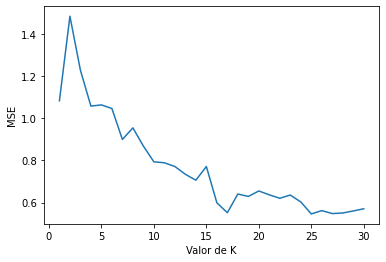

In [8]:
best_rmse = 1
k_neighbors = 0

k_range = range(1, 31)
k_scores = []
for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    loss = abs(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
    if loss.mean() < best_rmse:
        best_rmse = loss.mean()
        k_neighbors = k
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K')
plt.ylabel('MSE')
plt.show()

#### Cria um classificador kNN

In [9]:
knn = KNeighborsClassifier(n_neighbors = k_neighbors)

#### Treina o classificador

In [10]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

## Etapa de Teste

#### Efetua a predição

In [11]:
Y_Pred = knn.predict(tfidf_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [12]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 94.2
precisao: 94.7


#### Tabela com os itens classificados errados na base de teste

In [13]:
d = []

for i in range(len(X_test)):
    au = tfidf_vectorizer.transform([X_test.values[i]])
    pred = knn.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,SUCO DE LARANJA INTEGRAL PRATS 900ML,SUCO LARANJA INTEGRAL,SUCO LARANJA
1,SUCO AURORA INT UVA BCO 1.5L,SUCO UVA INTEGRAL,SUCO UVA
2,SUCO SUVALAN MACA LARANJA BETERRABA 1LT,SUCO LARANJA,SUCO UVA
3,SUCO TANG UVA 30G,SUCO UVA,SUCO LARANJA
4,GUARANA ZR LATA,GUARANA ANTARTICA,FANTA
...,...,...,...
57,SUCO CASA PERINI INTEG UVA 1L GF,SUCO UVA INTEGRAL,SUCO UVA
58,REF LATA FANTA GUARANA 200ML PET,GUARANA ANTARTICA,FANTA
59,SUCO FRAMB E UVAS BRAN INTEG NOBRE COLHE,SUCO UVA INTEGRAL,CINI REFRIGERANTE
60,SUCO ALIANCA UVA TINTO INTEG 450ML,SUCO UVA INTEGRAL,SUCO UVA


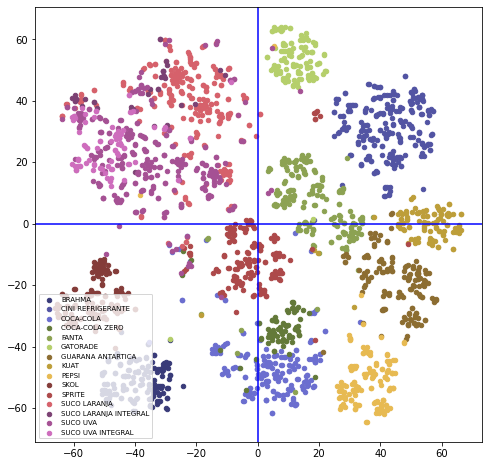

In [14]:
model = TSNE(n_components=2, init='pca', random_state=0)
transformed = model.fit_transform(X_train.todense())

fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], c=[plt.cm.tab20b(float(g)/15)], s=20, label = le.inverse_transform([g])[0])

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Matriz de Confusão

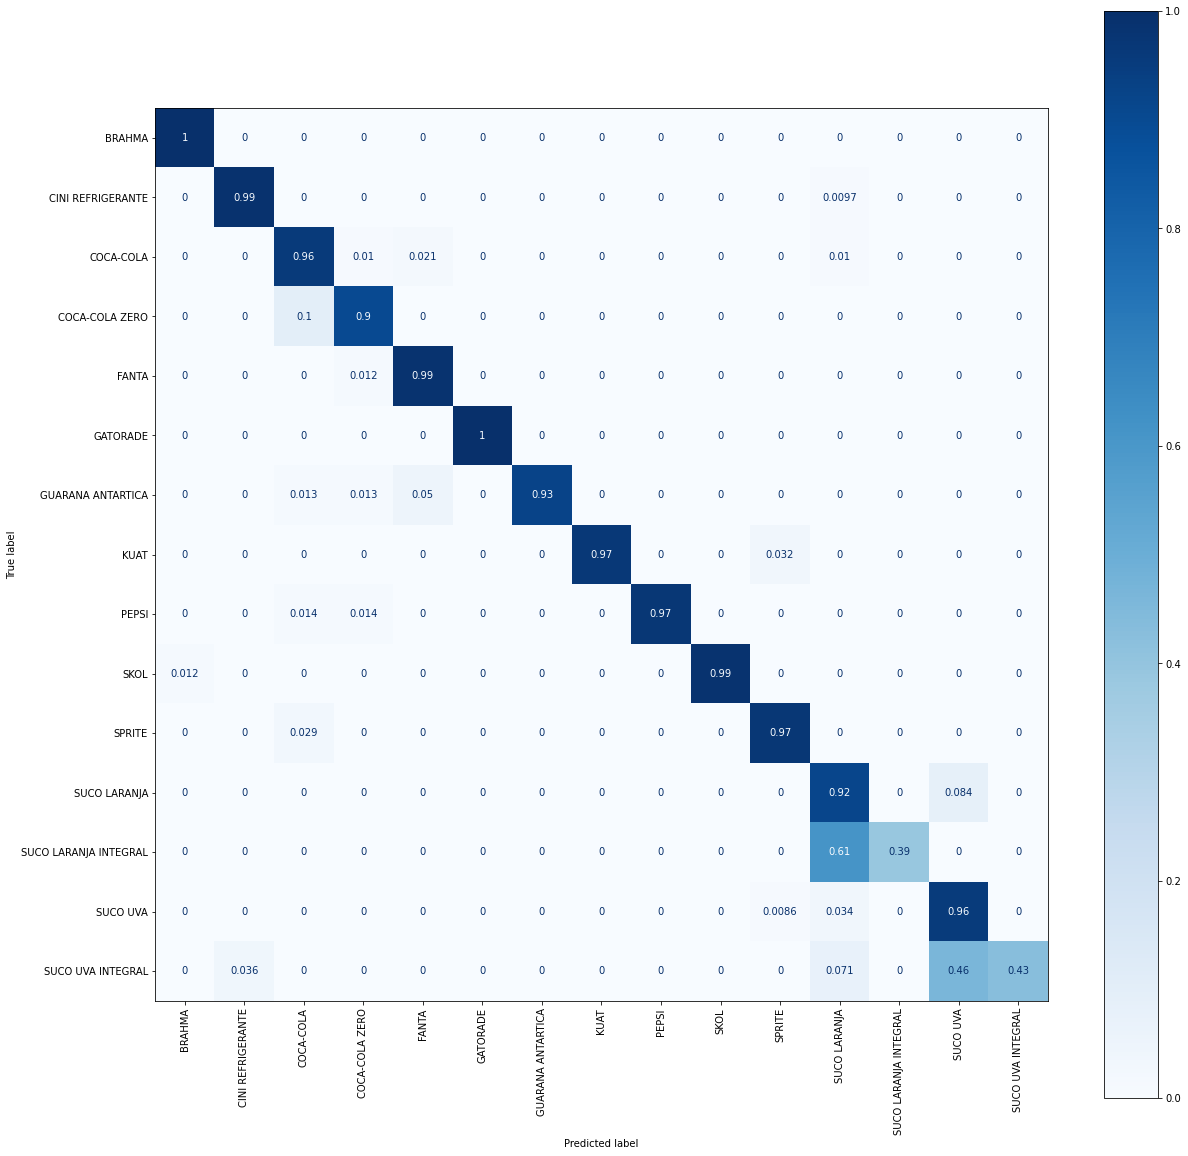

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(
    knn,
    tfidf_vectorizer.transform(X_test).toarray(),
    y_test,
    display_labels=np.unique(le.inverse_transform(y_test)),
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax,
    xticks_rotation='vertical'
)